## Part 1:

## Reading the data:
    For reading the data, we are using pandas, it will read the data from the data directory and load it into a dataframe.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Reference for downloading the data set : https://www.kaggle.com/joniarroba/noshowappointments
df = pd.read_csv("data/KaggleV2-May-2016.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


## Remove records with erroneous entries :

    Missing data reduce the representativeness of the sample and can therefore distort inferences about the population. So we will check if our data set has any missing values in it.

In [2]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

In [3]:
get_percentage_missing(df)

PatientId         0.0
AppointmentID     0.0
Gender            0.0
ScheduledDay      0.0
AppointmentDay    0.0
Age               0.0
Neighbourhood     0.0
Scholarship       0.0
Hipertension      0.0
Diabetes          0.0
Alcoholism        0.0
Handcap           0.0
SMS_received      0.0
No-show           0.0
dtype: float64

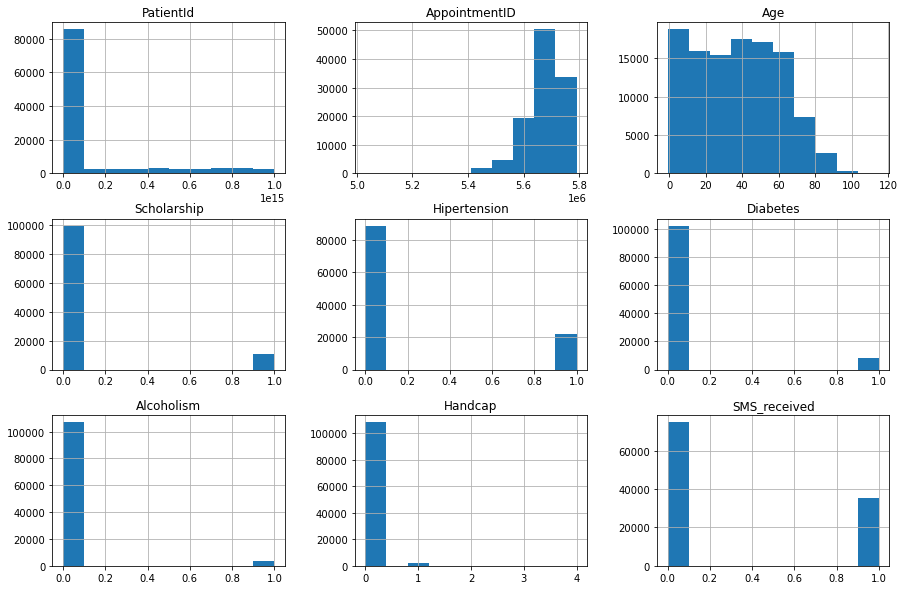

In [4]:

## Plotting all the numeric columns to get an idea of their data distribution

import matplotlib.pyplot as plt
df.hist(layout=(3,3), figsize=(15,10))

plt.show()

In [5]:
## We will not be considering PatientID and Appointment ID in our training columns. Because our data samples are 
## independent and identically distributed so we can remove the sample IDs. It is given that all samples come 
## from or refer to the same source/object and they don't somehow identify the sample class.

df.pop('PatientId')
df.pop('AppointmentID')

print("Columns excluded : PatientId & AppointmentID")

Columns excluded : PatientId & AppointmentID


In [6]:
## By looking at the distributions above, we saw that age variable has some erroneous entries in it, so we will
## settle them first.

## We know that age of a person cannot be less than zero or greater than a certain amount, so we will replace all
##these erroneous entries with NaN, later on we will replace them in our pipeline.

df['Age'] = df['Age'].mask(df['Age'].sub(df['Age'].mean()).div(df['Age'].std()).abs().gt(2))

## Seperating training and test data:

In [7]:
## Using stratified sampling on the No-show variable to ensure test set and training set class proportions 
## are the same


from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.189, random_state=1234)
for train_index, test_index in split.split(df, df["No-show"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

In [8]:
## Saving the train and test sets as csv files in the processed_data directory

train_set.to_csv("./processed_data/Trainingdata.csv",index=False)
test_set.to_csv("./processed_data/Testdata.csv",index=False)


In [9]:
## Seperating the independent and dependent variables
X=train_set.loc[:, train_set.columns != 'No-show'] # It will contains all columns except our target column
Y=train_set.loc[:, train_set.columns == 'No-show'] #It will contain target column

## Plot the No-show variable against the other variables in the dataset:

In [10]:
#numerical features
num_cols = X.select_dtypes([int, float]).columns

## Converting target categorical column to numeric column

from sklearn.preprocessing import LabelEncoder
y_converted = LabelEncoder().fit_transform(np.ravel(Y))

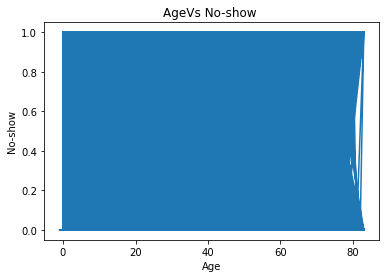

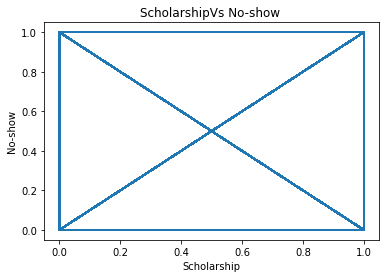

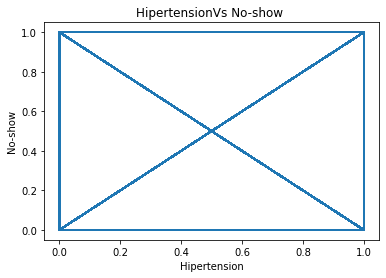

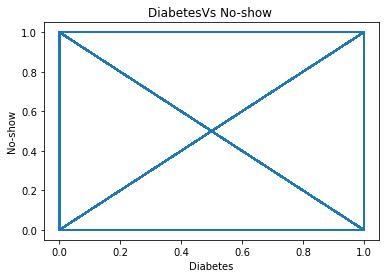

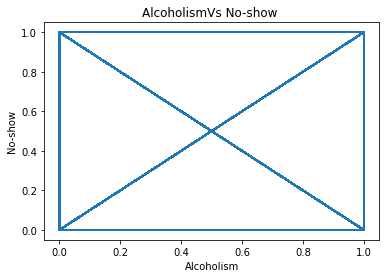

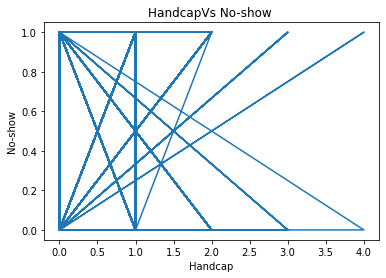

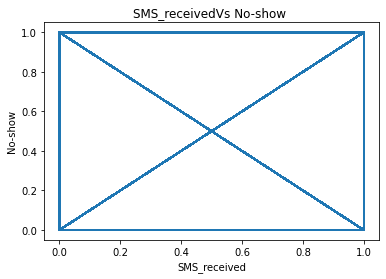

In [11]:
for i in num_cols:
    plt.plot(X[i],y_converted)
    plt.title(i+"Vs No-show ")
    plt.xlabel(i+"")
    plt.ylabel("No-show")
    plt.show()

In [12]:
!pip install sklearn_pipeline_utils
!pip install sklearn_pandas

## Creating a preprocessing pipeline:

In [13]:
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn_pandas import DataFrameMapper

class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, method='mean', to_fill_with='NA'):
        self.method = method
        self.fill = to_fill_with

    def fit(self, X, y=None):
        if self.method in ['mean', 'median']:
            if not all([dtype in [np.number, np.int] for dtype in X.dtypes]):
                raise ValueError('Only mean median and mode method is supported')
        if self.method == 'mean':
            self.fill = X.mean()
        elif self.method == 'median':
            self.fill = X.median()
        elif self.method == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.method == 'fill':
            if type(self.fill) is list and type(X) is pd.DataFrame:
                self.fill = dict([(cname, v) for cname, v in zip(X.columns, self.fill)])
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [14]:
## Making our own pipeline for numerical data

numerical_data_pipeline = DataFrameMapper(
        [(X.select_dtypes([int, float]).columns,
        CustomImputer(method='median'), {'alias': 'numerical_data'}
        )    
        ],input_df=True ,df_out=True)



from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaled_numerical_pipeline = make_pipeline(
    numerical_data_pipeline,
    StandardScaler(),
    MinMaxScaler()
)



In [15]:
numerical_data_pipeline.fit_transform(X)

,numerical_data_0,numerical_data_1,numerical_data_2,numerical_data_3,numerical_data_4,numerical_data_5,numerical_data_6
64781,35.0,0,0,0,0,0,1
33727,52.0,1,0,0,0,0,0
13711,12.0,0,0,0,0,0,0
104875,50.0,0,0,0,0,0,0
51299,17.0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
94003,0.0,0,0,0,0,0,0
20314,18.0,0,0,0,0,0,0
83679,71.0,0,0,1,0,0,0
50014,36.0,0,0,0,0,0,0


In [16]:
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder,LabelEncoder
from sklearn_pandas import gen_features

impute_mode_cols = gen_features(
    columns=X.select_dtypes('object').columns,
    classes=[
        {'class':CustomImputer,'method':'mode'},
        {'class':LabelEncoder}
    ]
)

In [17]:
from sklearn.pipeline import FeatureUnion, make_union

categorical_data_pipeline = make_union(
    DataFrameMapper(impute_mode_cols, input_df=True, df_out=True)
)
categorical_data_pipeline.fit_transform(X)

array([[    0,  4137,     2,    38],
       [    0, 45699,    10,    36],
       [    0, 13767,    16,    24],
       ...,
       [    1,  8570,     4,    36],
       [    0, 17503,    13,    39],
       [    0, 35022,     5,    23]])

In [18]:
## Final pipeline for pre-processing our features
features_pipeline = make_union(scaled_numerical_pipeline, 
                      categorical_data_pipeline)

In [19]:
final_X = features_pipeline.fit_transform(X)

In [20]:
final_dataframe = pd.concat([ pd.DataFrame(y_converted),pd.DataFrame(final_X)] ,axis=1)

In [21]:
final_dataframe.to_csv("Trainingdata.csv",index=False)

## Part 2:

## Reading the data:
    For reading the data, we are using pandas, it will read the data from the preprocessed data directory and load it into a dataframe.

In [22]:
import pandas as pd

import warnings ## To ignore the warnings
warnings.filterwarnings('ignore')

traindf = pd.read_csv("Trainingdata.csv")


## Seperating the independent and dependent variables

In [23]:

X_train=traindf.loc[:, traindf.columns != '0'] # It will contains all columns except our target column
y_train=traindf.loc[:, traindf.columns == '0'] #It will contain target column

## K Fold cross validation:

In [24]:
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score
import numpy as np
import matplotlib.pyplot as plt


def k_fold_cross_validation(training_columns, labels, Classifier, name_of_model): 
 

    kf = KFold( shuffle=True,n_splits=10)# Initializing KFold object with 10 as k-value
    accs=[]
    training_columns_train_array = []
    labels_train_array = []
    training_columns_test_array = []
    labels_test_array = []
    iter = 0
    print("Applying K fold cv algorithm for :", (name_of_model))
    for training_indices, test_indices in kf.split(training_columns):
        iter += 1
        print("iter ", iter)
        training_columns_train_cv, labels_train_cv = training_columns.iloc[training_indices], labels.iloc[training_indices]
        training_columns_test_cv, labels_test_cv = training_columns.iloc[test_indices], labels.iloc[test_indices]
        training_columns_train_array.append(training_columns_train_cv) # adding training score for  the given iteration
        training_columns_test_array.append(training_columns_test_cv) # adding test score for iteration
        labels_train_array.append(labels_train_cv)  # adding training labels for  the given iteration
        labels_test_array.append(labels_test_cv)  # adding test labels for  the given iteration
        print("Shape of training training_columns: ", training_columns_train_cv.shape)
        print("Shape of test training_columns: ", training_columns_test_cv.shape)
        Classifier.fit(training_columns_train_cv, labels_train_cv) 
        preds = Classifier.predict(training_columns_test_cv)
        score = accuracy_score(preds, labels_test_cv) # Calculating acc
        accs.append(score) # adding k-fold  acc for each iter
    print("List of k-fold  accs for {}: ".format(name_of_model), accs)
    average_acc = np.mean(accs)
    print("\nAverage k-fold  acc for {}: ".format(name_of_model), average_acc)
    print("\nBest k-fold  acc for {}: ".format(name_of_model), max(accs))
    maximum_acc_index = accs.index(max(accs)) # best k-fold  acc
    maximum_acc_training_columns_train = training_columns_train_array[maximum_acc_index] # training training_columns corresponding to best k-fold  acc
    maximum_acc_training_columns_test = training_columns_test_array[maximum_acc_index] # test training_columns corresponding to best k-fold  acc
    maximum_acc_labels_train = labels_train_array[maximum_acc_index] # training labels corresponding to best k-fold  acc
    maximum_acc_labels_test = labels_test_array[maximum_acc_index] # test labels corresponding to best k-fold  acc

 

    return average_acc, maximum_acc_training_columns_train, maximum_acc_training_columns_test, maximum_acc_labels_train, maximum_acc_labels_test,accs



## To visualize the performance of each Classifier, we will be noting its  accuracy
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
def evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, targets, regr): 
    regr.fit(max_acc_data_train, max_acc_targets_train) #
    targets_pred = regr.predict(max_acc_data_test) # Prediction on test data
    
    print("roc_auc_score")
    rep = roc_auc_score(max_acc_targets_test, targets_pred)
    print(rep)
    
    
    

## Simple Classification models with default parameters:

Applying K fold cv algorithm for : DT
iter  1
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  2
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  3
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  4
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  5
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  6
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  7
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  8
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  9
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  10
Shape of training training_columns:  (80674,

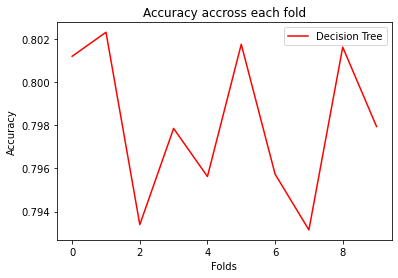

In [25]:
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(min_impurity_decrease=0.4) # DT Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "DT") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

## Comparision through graphs


## argument has accuracy values
plt.plot(dt_scores,color='r',label="Decision Tree")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

Applying K fold cv algorithm for : RF
iter  1
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  2
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  3
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  4
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  5
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  6
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  7
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  8
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  9
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  10
Shape of training training_columns:  (80674,

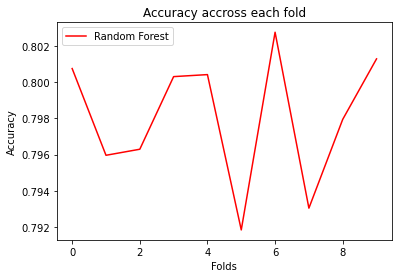

In [26]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(min_impurity_decrease=0.3) # DT Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "RF") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

## Comparision through graphs


## argument has accuracy values
plt.plot(dt_scores,color='r',label="Random Forest")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

Applying K fold cv algorithm for : LinearSVC
iter  1
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  2
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  3
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  4
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  5
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  6
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  7
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  8
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  9
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  10
Shape of training training_columns:  

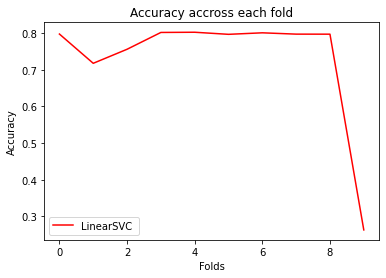

In [27]:
from sklearn.svm import LinearSVC


clf = LinearSVC() #  Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "LinearSVC") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

## Comparision through graphs


## argument has accuracy values
plt.plot(dt_scores,color='r',label="LinearSVC ")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

Applying K fold cv algorithm for : SVC
iter  1
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  2
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  3
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  4
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  5
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  6
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  7
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  8
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  9
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  10
Shape of training training_columns:  (80674

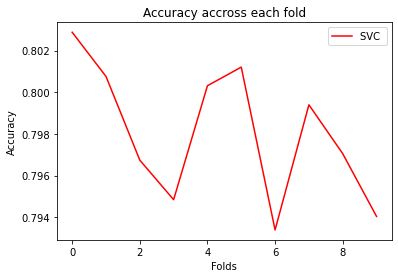

In [28]:
from sklearn.svm import SVC


clf = SVC(kernel='rbf') #  Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train[:100000], y_train[:100000], clf, "SVC") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

## Comparision through graphs


## argument has accuracy values
plt.plot(dt_scores,color='r',label="SVC ")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

### Reporting estimated performances. 

| Classifier | AUC score | Accuracy |
| --- | --- | --- |
| RF | .56 | .79 |
| DT | .60 | .73 |
| Linear SVC | .5 | .80 |
| Rbf SVC | .5 | .80 |


### Should you use accuracy or AUC as a metric for this task?

    AUC is in fact often preferred over accuracy for binary classification. Although both metrics have intuitive interpretations. For this task AUC is prefered. The reason for this is that computing the AUC is equivalent to defining a misclassification loss function (which reflects the relative gravity of misclassifying one class over the other), and averaging it over the distribution of the scores of the points in your dataset. The problem here is that those scores are produced by the fitted model, and as such they change whenever we change the model itself, be it the type of algorithm or just the parameters/hyperparameters.

## Hyper parameter tuning:

In [29]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
model = DecisionTreeClassifier()

min_impurity_decreases = [0.1,0.5,0.8]
max_depths = [None, 5, 10, 15]
max_leaf_Nodes = [None, 10,100]
# define grid search
from sklearn.model_selection import GridSearchCV
grid = dict(min_impurity_decrease=min_impurity_decreases,max_depth=max_depths,max_leaf_nodes=max_leaf_Nodes)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X_train, y_train)
# summarize results

print("Best: parameters %s" % ( grid_result.best_params_))

Best: parameters {'max_depth': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.1}


In [30]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [80, 90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 3)


# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


{'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

Applying K fold cv algorithm for : DT
iter  1
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  2
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  3
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  4
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  5
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  6
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  7
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  8
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  9
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  10
Shape of training training_columns:  (80674,

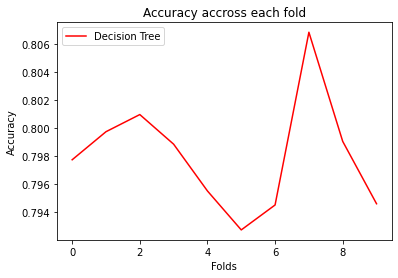

In [31]:
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=None, min_impurity_decrease=0.1) # DT Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "DT") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

## Comparision through graphs


## argument has accuracy values
plt.plot(dt_scores,color='r',label="Decision Tree")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

Applying K fold cv algorithm for : RF
iter  1
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  2
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  3
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  4
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  5
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  6
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  7
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  8
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  9
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  10
Shape of training training_columns:  (80674,

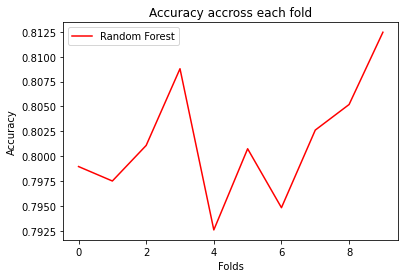

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=80,
 max_features=3,
 min_samples_leaf=3,
 min_samples_split=10,
 n_estimators=100) # DT Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "RF") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

## Comparision through graphs


## argument has accuracy values
plt.plot(dt_scores,color='r',label="Random Forest")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

###  Estimated performance for the tuned classifiers.

| Classifier | AUC score | Accuracy |
| --- | --- | --- |
| RF | .52 | .80 |
| DT | .5 | .80 |

## SVM:

In [33]:
class svc:
    def __init__(self , C = 0.01 , number_of_iterations = 100 , learning_rate = 0.1):
 
        self.c = C
        self.iteration = number_of_iterations
        self.lr = learning_rate
            
    def fit(self , x , y):
        self.x = x
        self.y = y
        
        w = np.zeros([1 , x.shape[1]])
        b = 0
        
        costs = np.zeros(self.iteration)
        for i in range(self.iteration):
            cost = x @ w.T + b
            b = b - self.lr * self.c * sum(cost - y) 
            w = w - self.lr * self.c * sum((cost - y)*x) 
            costs[i] = self.c * sum( (y * cost)  + (1 - y)*cost ) + (1/2)* sum(w.T**2)
        
        self.w = w
        self.b = b 
        self.costs = costs
        
    
    def predict(self , x_test):
        pred_y =  []
        svc = x_test @ self.w.T + self.b
        for i in svc:
            if i >= 0:
                pred_y.append(1)
            else:
                pred_y.append(0)
        
        return pred_y

In [34]:
clf = svc()

clf.fit(X_train.values, y_train.values.reshape([len(y_train) , 1]))

In [35]:
preds = clf.predict(X_train.values)
print("Accuracy for our custom SVM is",accuracy_score(preds,y_train))


Accuracy for our custom SVM is 0.79806329975345


### Performance comparison

    We have very similar results for SVM implemented in sklearn and our own custome implementation.  In the case of the simple SVM we used "linear" kernel. However, the performance of sklearn provides rbf kernel too, which has better performance than simple linear classsifier.

## Part 3:

## Training an AdaBoost classifier:

Applying K fold cv algorithm for : AB
iter  1
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  2
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  3
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  4
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  5
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  6
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  7
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
iter  8
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  9
Shape of training training_columns:  (80674, 11)
Shape of test training_columns:  (8963, 11)
iter  10
Shape of training training_columns:  (80674,

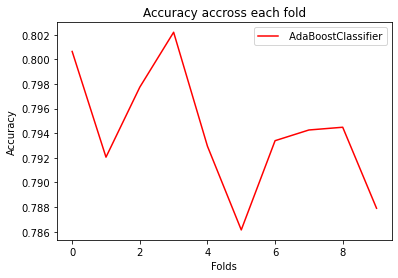

In [36]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier() # AD Model
DT_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,dt_scores = k_fold_cross_validation(X_train, y_train, clf, "AB") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

## Comparision through graphs



## argument has accuracy values
plt.plot(dt_scores,color='r',label=" AdaBoostClassifier")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

## Train an XGBoost classifier:

Applying K fold cv algorithm for : XGB
iter  1
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
[14:37:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
iter  2
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
[14:37:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
iter  3
Shape of training training_columns:  (80673, 11)
Shape of test training_columns:  (8964, 11)
[14:38:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed

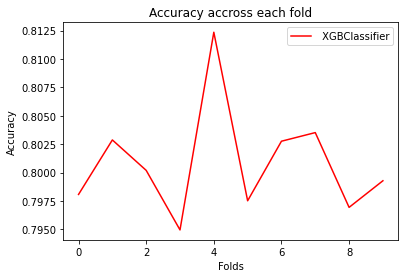

In [37]:
import xgboost as xgb


clf = xgb.XGBClassifier() # AD Model
clf_mean_accuracy, max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test,clf_scores = k_fold_cross_validation(X_train, y_train, clf, "XGB") # cross-validation
evaluate(max_acc_data_train, max_acc_data_test, max_acc_targets_train, max_acc_targets_test, y_train, clf) #  confusion matrix

## Comparision through graphs



## argument has accuracy values
plt.plot(clf_scores,color='r',label=" XGBClassifier")
plt.legend(loc="best")

plt.title("Accuracy accross each fold") ## Setting subtitle of fig 1
plt.xlabel("Folds") ## Setting x-label of fig 1
plt.ylabel("Accuracy"); ## Setting y-label of fig 1

## Blending Model:

In [41]:

from numpy import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def get_classifiers():
    """Function to add the classifiers that we want to keep in our blending model"""
    classifiers = []
    classifiers.append(('lr', LogisticRegression()))
    classifiers.append(('xgb', xgb.XGBClassifier()))
    classifiers.append(('cart', DecisionTreeClassifier()))
    classifiers.append(('Adb', AdaBoostClassifier()))
    classifiers.append(('Rf', RandomForestClassifier()))
    return classifiers

def fit_blending_model(classifiers, X_train_full, y_train_full):
    """
    This function will perform the following steps
    
    
    1 Creates a validation set using 20% of the training set
    2 Trains each of your chosen classifiers on the training set
    3 Using the validation set creates a new dataset where features are predictions made by each of your chosen classifiers
    4 Trains a logistic regression classifier to blend the predictions


    """
    
    # split training set into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)


    # fit all classifiers on the training set and predict on hold out set
    new_features = list()
    for name, model in classifiers:
        # fit in training set
        model.fit(X_train, y_train)
        # predict on hold out set
        y_preds = model.predict(X_val)
        # reshape predictions into a matrix with one column
        y_preds = y_preds.reshape(len(y_preds), 1)
        # store predictions as input for blending
        new_features.append(y_preds)
    # create 2d array from predictions, each set is an input feature
    new_features = hstack(new_features)
    # define blending model
    clf_blender = LogisticRegression()
    # fit on predictions from base classifiers
    clf_blender.fit(new_features, y_val)
    return clf_blender

def prediction_using_blending(classifiers, clf_blender, X_test):
    # make predictions with base classifiers
    new_features = list()
    for name, model in classifiers:
        # predict with base clf
        y_preds = model.predict(X_test)
        y_preds = y_preds.reshape(len(y_preds), 1)
        new_features.append(y_preds)
    new_features = hstack(new_features)
    # predict
    return clf_blender.predict(new_features)


In [42]:
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=1)
# create the base classifiers
classifiers = get_classifiers()
# train the blending ensemble
clf_blender = fit_blending_model(classifiers, X_train_full, y_train_full)
# make predictions on test set
y_preds = prediction_using_blending(classifiers, clf_blender, X_test)
# evaluate predictions
score = roc_auc_score(y_test, y_preds)
acc = accuracy_score(y_test, y_preds)

print('Blending AUC score: %.3f' % (score*100))
print('Blending Accuracy: %.3f' % (acc*100))

[15:28:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Blending AUC score: 51.958
Blending Accuracy: 80.463
